In [1]:
import os

os.chdir('D:/GNN/overlapping-community-detection-master/')#更改路径，''里面为更改的路径

import nocd
import matplotlib.pyplot as plt
import numpy as np
import scipy.sparse as sp
import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.preprocessing import normalize



%matplotlib inline

torch.set_default_tensor_type(torch.cuda.FloatTensor)

In [2]:
hidden_sizes = [128]    # hidden sizes of the GNN
weight_decay = 1e-2     # strength of L2 regularization on GNN weights
dropout = 0.5           # whether to use dropout
batch_norm = True       # whether to use batch norm
lr = 1e-3               # learning rate
max_epochs = 5000        # number of epochs to train
display_step = 25       # how often to compute validation loss
balance_loss = True     # whether to use balanced loss
stochastic_loss = True  # whether to use stochastic or full-batch training
batch_size = 20000      # batch size (only for stochastic training)

In [107]:
#loader = nocd.data.load_dataset('data/mag_cs.npz')
# loader=nocd.data.load_dataset('data/facebook_ego/fb_414.npz')
# A, X, Z_gt = loader['A'], loader['X'], loader['Z']
# N, K = Z_gt.shape

# x_norm = normalize(X)  # node features
# # x_norm = normalize(A)  # adjacency matrix
# # x_norm = sp.hstack([normalize(X), normalize(A)])  # concatenate A and X
# x_norm = nocd.utils.to_sparse_tensor(x_norm).cuda()

# sampler = nocd.sampler.get_edge_sampler(A, batch_size, batch_size, num_workers=5)
# gnn = nocd.nn.GCN(x_norm.shape[1], hidden_sizes, K, batch_norm=batch_norm, dropout=dropout).cuda()
# adj_norm = gnn.normalize_adj(A)
# decoder = nocd.nn.BerpoDecoder(N, A.nnz, balance_loss=balance_loss)
# opt = torch.optim.Adam(gnn.parameters(), lr=lr)

In [75]:
from scipy import sparse

# result in 03-01
A = sparse.load_npz('D:\\GNN\\OCD\\A_work.npz')
#X=sparse.load_npz('X_0526.npz')
X=sparse.load_npz('D:\\GNN\\OCD\\X_node2vec_work.npz') #deepwalk
#X=sparse.load_npz('Xnode2vec_0301.npz')

# result in 03-02
#A = sparse.load_npz('A_0302.npz') 
#X=sparse.load_npz('X_0302.npz')
#X=sparse.load_npz('Xdeep_0922.npz')
# log transform
# A_log=np.log(A.todense())
# A_log[np.isinf(A_log)]=0
# A=sp.csc_matrix(A_log)

lr = 1e-3               # learning rate


x_norm = normalize(X)  # node features
# x_norm = normalize(A)  # adjacency matrix
# x_norm = sp.hstack([normalize(X), normalize(A)])  # concatenate A and X
x_norm = nocd.utils.to_sparse_tensor(x_norm).cuda()


N=X.shape[0]
K=5

sampler = nocd.sampler.get_edge_sampler(A, batch_size, batch_size, num_workers=5)
gnn = nocd.nn.GCN(x_norm.shape[1], hidden_sizes, K, batch_norm=batch_norm, dropout=dropout).cuda()
adj_norm = gnn.normalize_adj(A)
decoder = nocd.nn.BerpoDecoder(N, A.nnz, balance_loss=balance_loss)
opt = torch.optim.Adam(gnn.parameters(), lr=lr)

adj_norm = gnn.normalize_adj(A)


In [84]:
val_loss = np.inf
validation_fn = lambda: val_loss
early_stopping = nocd.train.NoImprovementStopping(validation_fn, patience=10)
model_saver = nocd.train.ModelSaver(gnn)

for epoch, batch in enumerate(sampler):
    if epoch > max_epochs:
        break
    if epoch % 25 == 0:
        with torch.no_grad():
            gnn.eval()
            # Compute validation loss
            Z = F.relu(gnn(x_norm, adj_norm))
            val_loss = decoder.loss_full(Z, A)
          #  print(f'Epoch {epoch:4d}, loss.full = {val_loss:.4f}, nmi = {get_nmi():.2f}')
            print(f'Epoch {epoch:4d}, loss.full = {val_loss:.4f}')
            # Check if it's time for early stopping / to save the model
            early_stopping.next_step()
            if early_stopping.should_save():
                model_saver.save()
            if early_stopping.should_stop():
                print(f'Breaking due to early stopping at epoch {epoch}')
                break
            
    # Training step
    gnn.train()
    opt.zero_grad()
    Z = F.relu(gnn(x_norm, adj_norm))
    ones_idx, zeros_idx = batch
    if stochastic_loss:
        loss = decoder.loss_batch(Z, ones_idx, zeros_idx)
    else:
        loss = decoder.loss_full(Z, A)
    loss += nocd.utils.l2_reg_loss(gnn, scale=weight_decay)
    loss.backward()
    opt.step()

Epoch    0, loss.full = 0.5543
Epoch   25, loss.full = 0.5541
Epoch   50, loss.full = 0.5529
Epoch   75, loss.full = 0.5532
Epoch  100, loss.full = 0.5539
Epoch  125, loss.full = 0.5524
Epoch  150, loss.full = 0.5537
Epoch  175, loss.full = 0.5524
Epoch  200, loss.full = 0.5536
Epoch  225, loss.full = 0.5521
Epoch  250, loss.full = 0.5539
Epoch  275, loss.full = 0.5546
Epoch  300, loss.full = 0.5549
Epoch  325, loss.full = 0.5542
Epoch  350, loss.full = 0.5532
Epoch  375, loss.full = 0.5515
Epoch  400, loss.full = 0.5521
Epoch  425, loss.full = 0.5546
Epoch  450, loss.full = 0.5527
Epoch  475, loss.full = 0.5552
Epoch  500, loss.full = 0.5536
Epoch  525, loss.full = 0.5528
Epoch  550, loss.full = 0.5547
Epoch  575, loss.full = 0.5541
Epoch  600, loss.full = 0.5531
Epoch  625, loss.full = 0.5529
Epoch  650, loss.full = 0.5525
Breaking due to early stopping at epoch 650


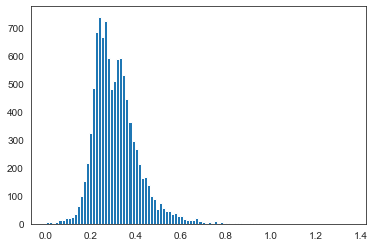

In [77]:
plt.hist(Z[Z > 0].cpu().detach().numpy(), 100);

In [78]:
thresh = 0.4

Z = F.relu(gnn(x_norm, adj_norm))

Z_pred = Z.cpu().detach().numpy() > thresh
model_saver.restore()
#print(f'Final nmi = {get_nmi(thresh):.3f}')

In [79]:
Z_pred

array([[ True, False, False, False, False],
       [False, False, False, False, False],
       [False, False, False, False, False],
       ...,
       [False,  True, False, False, False],
       [False,  True, False, False, False],
       [False,  True, False, False, False]])

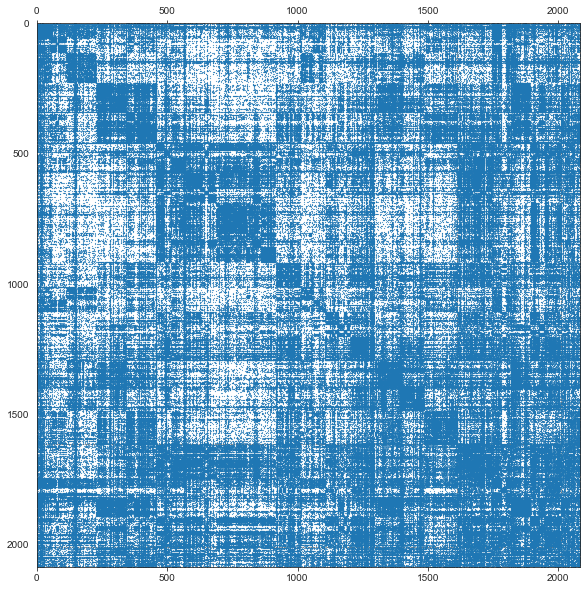

In [80]:
plt.figure(figsize=[10, 10])
z = np.argmax(Z_pred, 1)
o = np.argsort(z)
nocd.utils.plot_sparse_clustered_adjacency(A, K, z, o, markersize=0.2)

In [81]:
metrics = nocd.metrics.evaluate_unsupervised(Z_pred, A)
print(f"Predicted communities:\n"
      f" - coverage    = {metrics['coverage']:.4f}\n"
      f" - conductance = {metrics['conductance']:.4f}\n"
      f" - density     = {metrics['density']:.3e}\n"
      f" - clust_coef  = {metrics['clustering_coef']:.3e}")

Predicted communities:
 - coverage    = 0.2539
 - conductance = 0.6692
 - density     = 4.487e-01
 - clust_coef  = -2.774e+03


In [11]:
print(Z_pred.sum(0))


[134  64  67  39 208 970  82 243 114  55]


In [53]:
Z_pred[150]

array([ True, False, False, False, False,  True, False, False, False,
       False])

In [82]:
np.savetxt('Z_work_0316.csv',Z_pred)

In [14]:
Z_pred

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [118]:
Z_np=Z.cpu().detach().numpy() 

In [119]:
type(Z_pred)

numpy.ndarray

In [120]:
Z_np

array([[0.14110067, 0.50138706, 0.36806408, ..., 0.26549926, 0.52544767,
        0.        ],
       [0.12274361, 0.9617492 , 0.40348327, ..., 0.35805073, 0.4758182 ,
        0.1989124 ],
       [0.4195723 , 0.54633933, 0.39643943, ..., 0.18938088, 0.36047876,
        0.        ],
       ...,
       [0.12358   , 0.42620724, 0.21184501, ..., 0.08151223, 0.14543217,
        0.27446043],
       [0.1856752 , 0.48361742, 0.15981765, ..., 0.1522545 , 0.18127494,
        0.21621682],
       [0.22419384, 0.38334376, 0.21061781, ..., 0.05402237, 0.28073037,
        0.20586771]], dtype=float32)